In [1]:
%pwd
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.externals import joblib
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from imblearn.combine import SMOTETomek
import pickle


#Random Number
r = 42
labels = ['CN', 'EMCI', 'LMCI', 'AD']
n_clusters = 2

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def plot(mat, lbl=None):
    #Heatmap
    plt.figure(figsize = (12,10))
    ax = sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.yticks(rotation=0) 
    plt.title('Random Forest Classification Results', fontsize=18)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    ax.hlines([3], *ax.get_xlim())
    ax.vlines([3], *ax.get_xlim())
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=mat.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=mat.shape[0], color='k',linewidth=4)
    ax.tick_params(axis='both', which='both', length=0)
    if lbl:
        plt.text(0.4, 0.225, 'False Negative:\n'+str(lbl[0])+' People', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        plt.text(0.4, 0.95, 'True Negative:\n'+str(lbl[1])+' Normal People', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        plt.text(0.9, 0.225, 'True Positive:\n'+str(lbl[2])+' Alzheimer People', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9, color = 'white')
        plt.text(0.9, 0.95, 'False Positive:\n'+str(lbl[3])+' People', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
    else:
        plt.text(0.4, 0.225, 'False Negative', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        plt.text(0.4, 0.95, 'True Negative', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        plt.text(0.9, 0.225, 'True Positive', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        plt.text(0.9, 0.95, 'False Positive', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)

In [3]:
#Heatmap Gene Expression
def geheatmap(X, c, title=''):
    #Gene Expression
    ge = pd.DataFrame()
    for t in labels:
        ge[t] = X.T[c[c==t].index].mean(axis=1)

    
    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 
    
    
    #Heatmap
    fig = plt.figure(figsize = (2*c.nunique(),100))
    plt.title(title, fontsize = 20)
    sns.heatmap(ge[:100], cmap='RdBu')

In [4]:
#Loading in data
df = pd.read_csv('Data/ADNI_Gene_Expression_Profile.csv', header=2)
df = df[6:]
df = df.drop(df.columns[[1, -1]], axis=1)
df = df.rename({'SubjectID':'ProbeSet', 'Unnamed: 2':'Gene'}, axis=1)
df = df.set_index(['Gene', 'ProbeSet'])
df = df.loc[df.index.dropna()]

dfanno = pd.read_csv('Data/ADNIMERGE.csv')
dfanno = pd.Series(dfanno['DX_bl'].values, index=dfanno['PTID'])
dfanno = dfanno.groupby(dfanno.index).last()
dfanno = dfanno.loc[df.columns]

C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (329,480) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Standardize
df = df.astype(float)
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)

In [6]:
#Variables and Acutal
X = df.T
y = dfanno
feature_list = list(X.columns)
print(y.value_counts())

#Oversampling
X, y = SMOTETomek(random_state=r, n_jobs=-1).fit_resample(X, y)

CN      260
LMCI    226
EMCI    215
AD       43
dtype: int64


In [7]:
y = pd.Series(y)

#Count
print(y.value_counts())

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

AD      260
EMCI    260
CN      260
LMCI    260
dtype: int64
Training Features Shape: (832, 48157)
Training Labels Shape: (832,)
Testing Features Shape: (208, 48157)
Testing Labels Shape: (208,)


In [8]:
y_Mut = y
for label in labels:
    if label!='AD':
        y_Mut = y_Mut.replace(label, 'NOT_AD')
print(y_Mut.head())
print(y_Mut.size)

0    NOT_AD
1    NOT_AD
2        AD
3    NOT_AD
4    NOT_AD
dtype: object
1040


In [9]:
#Outer Random Forest
rf = RandomForestClassifier(n_estimators = 1000, random_state=r, oob_score=True, verbose=1, n_jobs = -1)
rf.fit(X_train, y_train) #Train
y_pred = rf.predict(X_test) #Predict

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Results: 
              precision    recall  f1-score   support

          AD       1.00      0.98      0.99        52
          CN       0.35      0.49      0.41        49
        EMCI       0.58      0.50      0.54        56
        LMCI       0.65      0.51      0.57        51

    accuracy                           0.62       208
   macro avg       0.65      0.62      0.63       208
weighted avg       0.65      0.62      0.63       208

Test:  0.6201923076923077
OOB Score:  0.5973557692307693


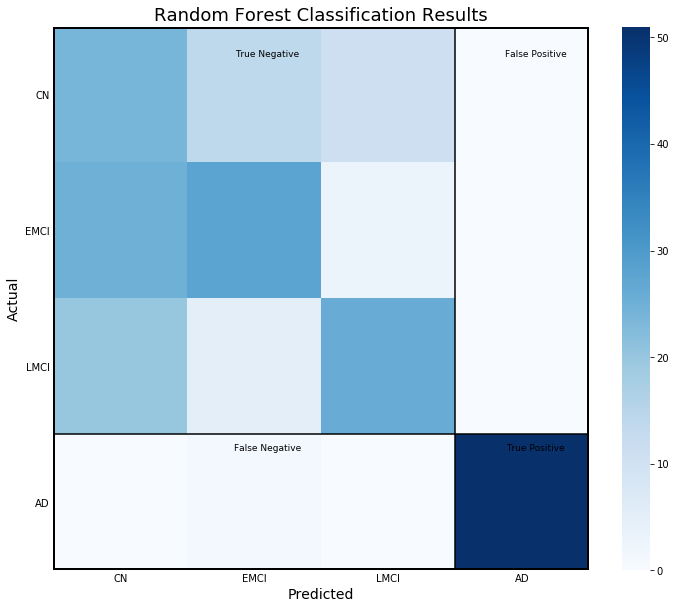

In [10]:
#Results
print("Results: ")
mat = confusion_matrix(y_test, y_pred, labels=labels)
print(classification_report(y_test,y_pred)) #Accuarcy
print('Test: ', accuracy_score(y_test, y_pred))
print('OOB Score: ', rf.oob_score_)
#Heatmap
plot(mat)

Text(0, 0.5, 'Gene')

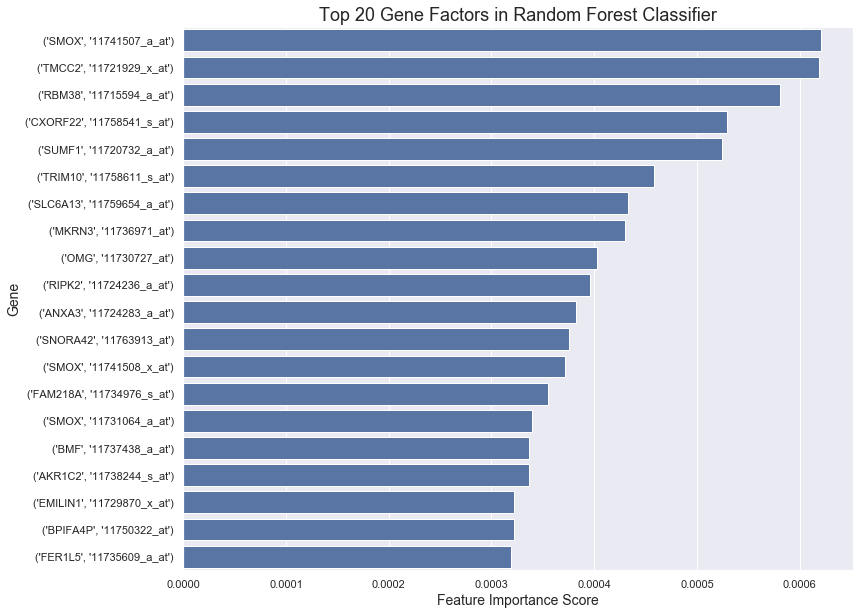

In [11]:
#Feature Importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

#Barplot
plt.figure(figsize = (12,10))
sns.set_color_codes('muted')
sns.set(font_scale=1)
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20], color = 'b', edgecolor = 'w')
plt.title('Top 20 Gene Factors in Random Forest Classifier', fontsize=18)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Gene', fontsize=14)

Gene     ProbeSet     
SMOX     11741507_a_at    0.000621
TMCC2    11721929_x_at    0.001239
RBM38    11715594_a_at    0.001820
CXORF22  11758541_s_at    0.002349
SUMF1    11720732_a_at    0.002873
                            ...   
RAC3     11729313_at      1.000000
OR9K2    11742330_at      1.000000
CALD1    11722531_a_at    1.000000
CHRDL2   11757002_a_at    1.000000
FAM221B  11750249_a_at    1.000000
Length: 48157, dtype: float64


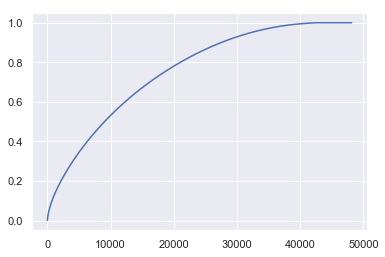

<Figure size 432x288 with 0 Axes>

In [12]:
feature_imp_cum = feature_imp.cumsum()
print(feature_imp_cum)
plt.plot(range(1, feature_imp_cum.size+1), feature_imp_cum)
plt.show()
plt.savefig('scree.png', format='svg', dpi=1200)

In [13]:
#Top 100 Genes
n_genes=100
X_train_i = X_train.loc[:, feature_imp.index[:n_genes]]
X_test_i = X_test.loc[:, feature_imp.index[:n_genes]]
X_i = X.loc[:, feature_imp.index[:n_genes]]
indexes = feature_imp.index[:n_genes]

In [14]:
#Inner Random Forest
rf_most_important = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=r, verbose=1, warm_start=False)

rf_most_important.fit(X_train_i, y_train)
y_pred_train = rf_most_important.predict(X_train_i)
y_pred = rf_most_important.predict(X_test_i)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Results: 
              precision    recall  f1-score   support

          AD       1.00      0.98      0.99        52
          CN       0.30      0.35      0.32        49
        EMCI       0.61      0.54      0.57        56
        LMCI       0.40      0.41      0.41        51

    accuracy                           0.57       208
   macro avg       0.58      0.57      0.57       208
weighted avg       0.59      0.57      0.58       208

Train:  1.0
Test:  0.5721153846153846
OOB Score:  0.5865384615384616


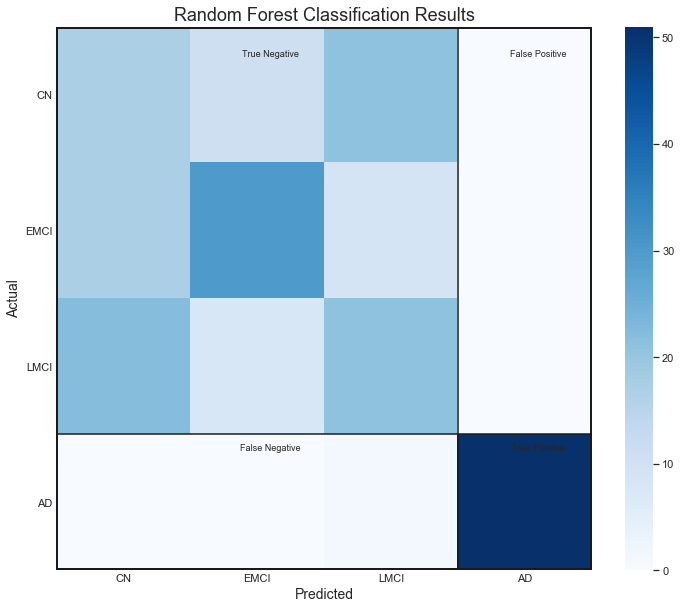

In [15]:
#Results
print("Results: ")
mat = confusion_matrix(y_test, y_pred, labels=labels)
print(classification_report(y_test,y_pred))
print('Train: ', accuracy_score(y_train, y_pred_train))
print('Test: ', accuracy_score(y_test, y_pred))
print('OOB Score: ', rf_most_important.oob_score_)

#Heatmap
plot(mat)

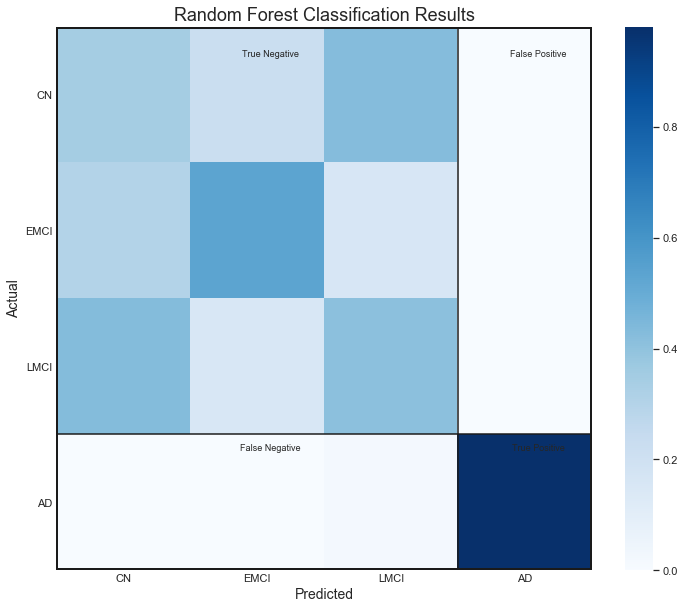

In [16]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
plot(mat)

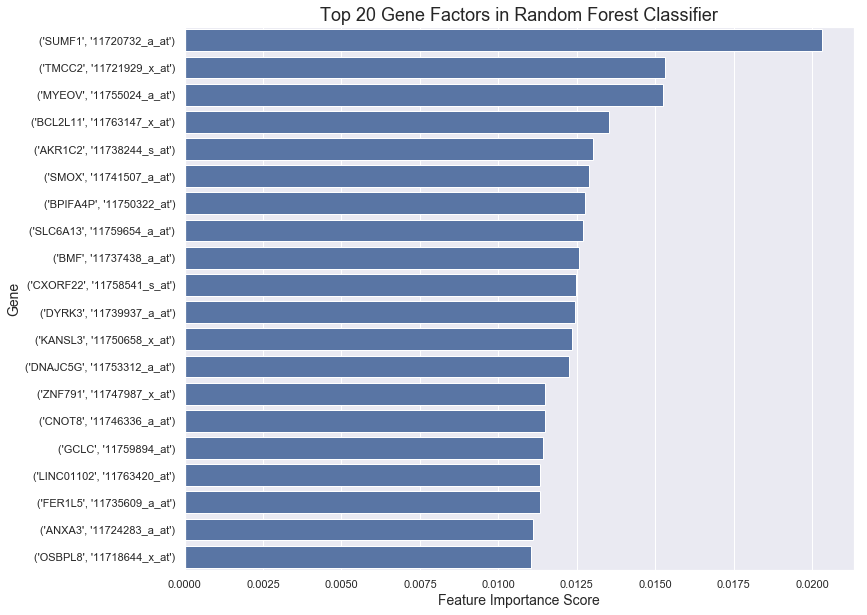

In [17]:
#Feature Importance
feature_imp = pd.Series(rf_most_important.feature_importances_,index=indexes).sort_values(ascending=False)

#Barplot
plt.figure(figsize = (12,10))
sns.set_color_codes('muted')
sns.set(font_scale=1)
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20], color = 'b', edgecolor = 'w')
plt.title('Top 20 Gene Factors in Random Forest Classifier', fontsize=18)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Gene', fontsize=14)
plt.savefig('B.png', bbox_inches = "tight", format='svg', dpi=1200)

Gene     ProbeSet     
SUMF1    11720732_a_at    0.020323
TMCC2    11721929_x_at    0.035650
MYEOV    11755024_a_at    0.050884
BCL2L11  11763147_x_at    0.064424
AKR1C2   11738244_s_at    0.077439
                            ...   
WDR59    11754255_a_at    0.972020
RIOK3    11725951_at      0.979222
CARM1    11754363_s_at    0.986264
RBFOX2   11745283_a_at    0.993134
OSBP2    11750705_a_at    1.000000
Length: 100, dtype: float64


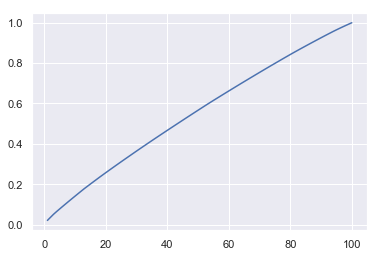

In [18]:
feature_imp_cum = feature_imp.cumsum()
print(feature_imp_cum)
plt.plot(range(1, feature_imp_cum.size+1), feature_imp_cum)
plt.show()

In [19]:
#Save genes
with open("genes.txt", "wb") as fp:   #Pickling
    pickle.dump(feature_imp.index, fp)

In [20]:
#5 Fold Cross Validation
y_pred = cross_val_predict(rf_most_important, X_i, y, cv=5, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]:

Results: 
              precision    recall  f1-score   support

          AD   0.945055  0.992308  0.968105       260
      NOT_AD   0.997392  0.980769  0.989011       780

    accuracy                       0.983654      1040
   macro avg   0.971224  0.986538  0.978558      1040
weighted avg   0.984308  0.983654  0.983785      1040

Accuracy:  0.9836538461538461


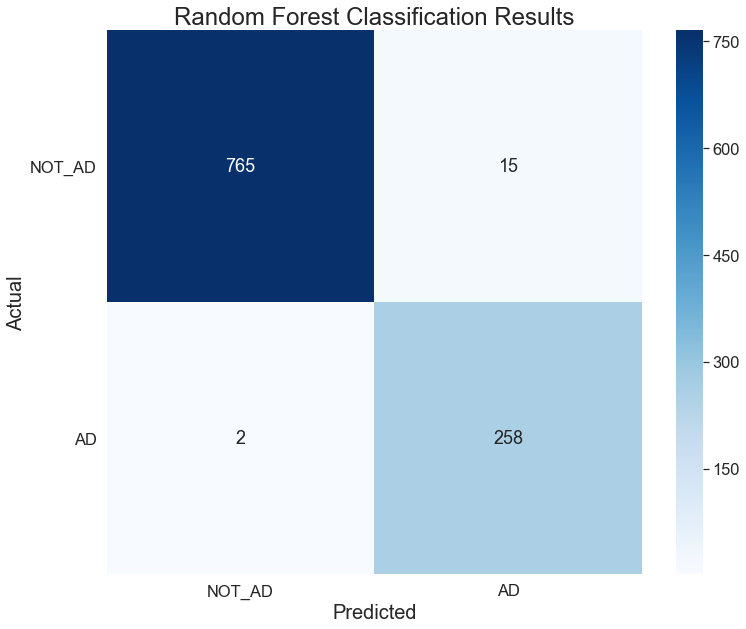

In [21]:
#Malignant vs Normal
y_pred_Mut = y_pred
for label in labels:
    if label!='AD':
        y_pred_Mut = np.where(y_pred_Mut==label, 'NOT_AD', y_pred_Mut)

#Results
print("Results: ")
mat = confusion_matrix(y_Mut, y_pred_Mut, labels=['NOT_AD', 'AD'])
print(classification_report(y_Mut, y_pred_Mut, digits=6))
print('Accuracy: ', accuracy_score(y_Mut, y_pred_Mut))
l = [mat[1][0], mat[0][0], mat[1][1], mat[0][1]]

#Heatmap
sns.set(font_scale=1.5)
plt.figure(figsize = (12,10))
sns.heatmap(mat, annot=True, cmap="Blues", fmt='g', xticklabels=['NOT_AD', 'AD'], yticklabels=['NOT_AD', 'AD'], annot_kws={"fontsize":18})
plt.yticks(rotation=0) 
plt.title('Random Forest Classification Results', fontsize=24)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.savefig('CM.png', format='svg', dpi=1200)
sns.set(font_scale=1)

In [22]:
classification_report(y_Mut, y_pred_Mut, digits=6)

'              precision    recall  f1-score   support\n\n          AD   0.945055  0.992308  0.968105       260\n      NOT_AD   0.997392  0.980769  0.989011       780\n\n    accuracy                       0.983654      1040\n   macro avg   0.971224  0.986538  0.978558      1040\nweighted avg   0.984308  0.983654  0.983785      1040\n'

Results: 
              precision    recall  f1-score   support

          AD   0.945055  0.992308  0.968105       260
          CN   0.380165  0.353846  0.366534       260
        EMCI   0.494297  0.500000  0.497132       260
        LMCI   0.480916  0.484615  0.482759       260

    accuracy                       0.582692      1040
   macro avg   0.575108  0.582692  0.578632      1040
weighted avg   0.575108  0.582692  0.578632      1040

Accuracy:  0.5826923076923077


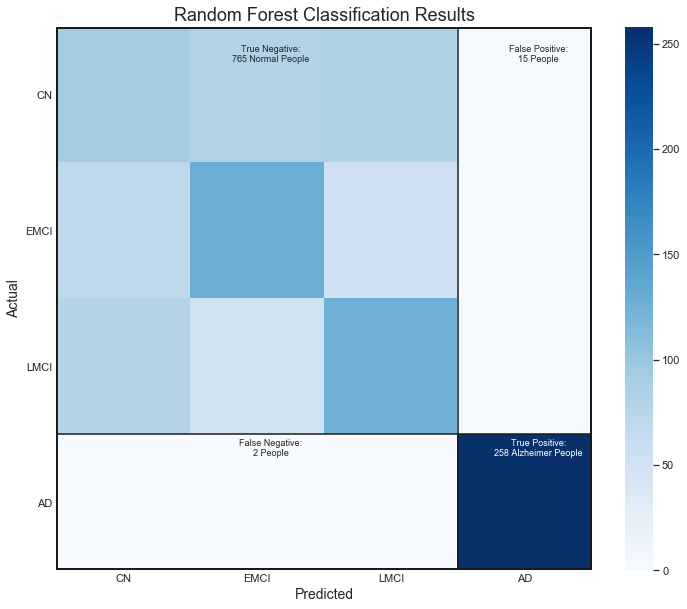

In [23]:
#Results
print("Results: ")
mat = confusion_matrix(y, y_pred, labels=labels)
print(classification_report(y, y_pred, digits=6))
print('Accuracy: ', accuracy_score(y, y_pred))
#Heatmap
plot(mat, lbl=l)

In [24]:
classification_report(y, y_pred, digits=6)

'              precision    recall  f1-score   support\n\n          AD   0.945055  0.992308  0.968105       260\n          CN   0.380165  0.353846  0.366534       260\n        EMCI   0.494297  0.500000  0.497132       260\n        LMCI   0.480916  0.484615  0.482759       260\n\n    accuracy                       0.582692      1040\n   macro avg   0.575108  0.582692  0.578632      1040\nweighted avg   0.575108  0.582692  0.578632      1040\n'

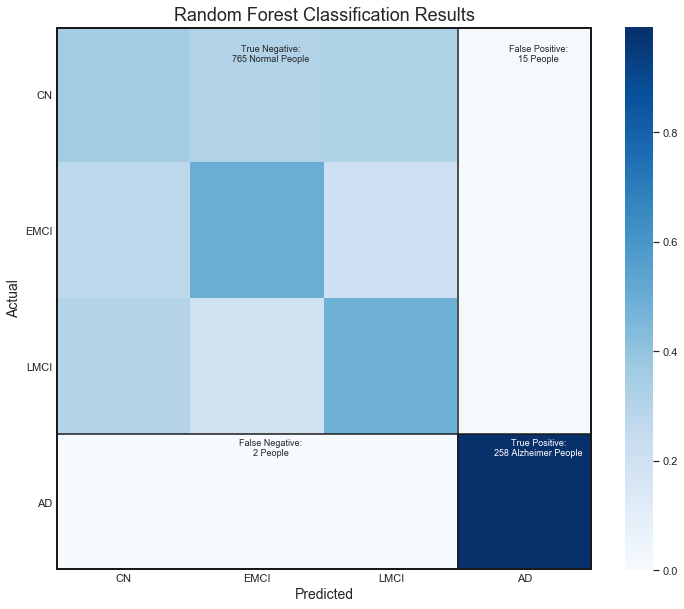

In [25]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
#Heatmap
plot(mat, lbl=l)
plt.savefig('hm.png', format='svg', dpi=1200)

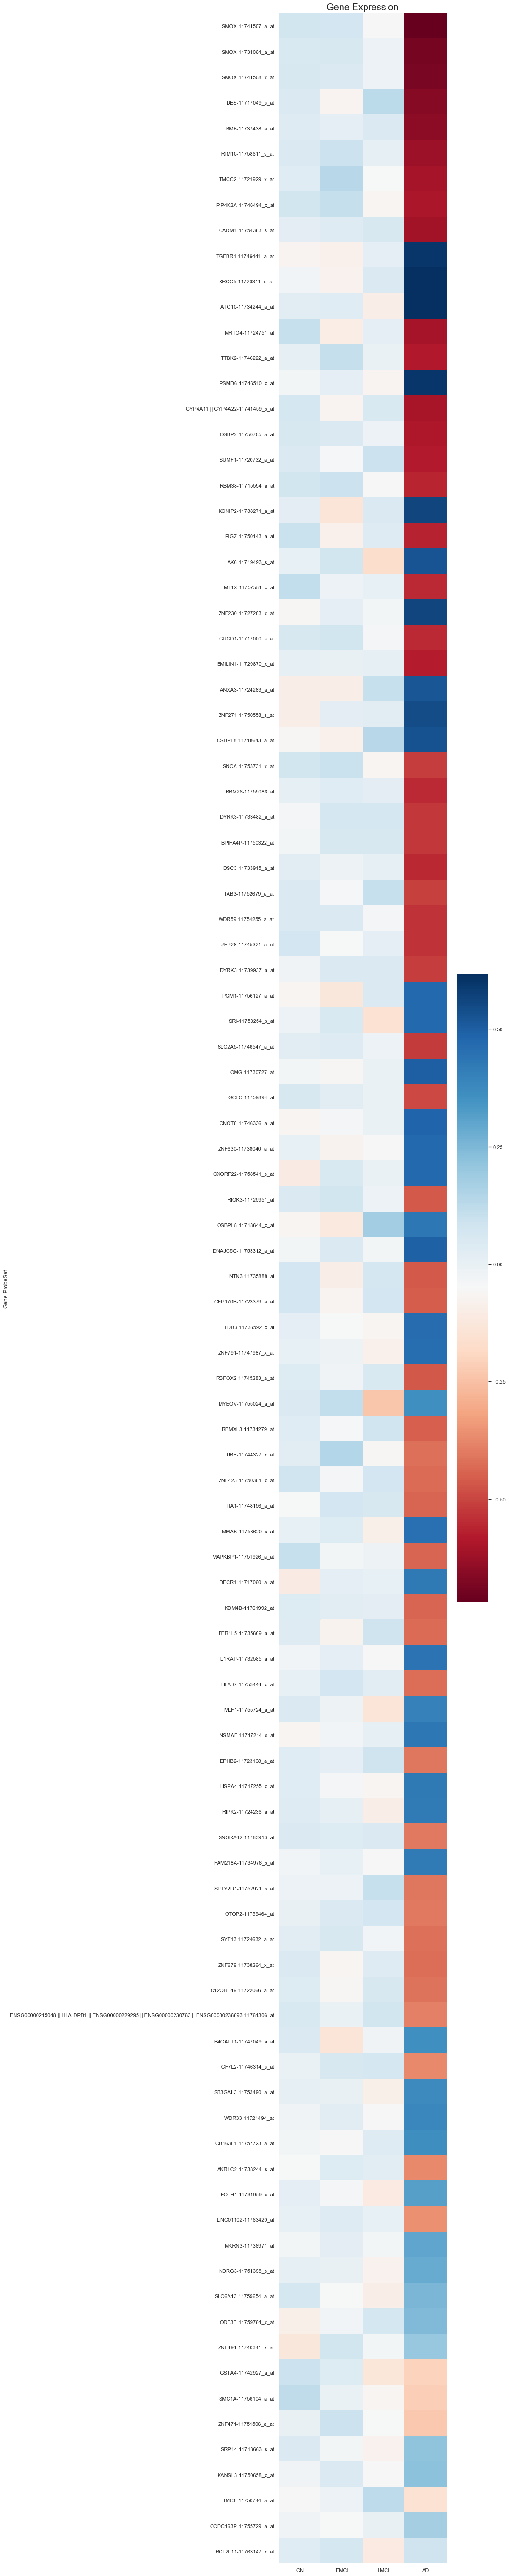

In [26]:
geheatmap(X_i, y, title='Gene Expression')
plt.savefig('ge.png', bbox_inches = "tight")

In [27]:
#Nerual Network
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', alpha=7.4e-5, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(560, 280, 140, 70),
              learning_rate='invscaling',
              learning_rate_init=0.006, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.1, random_state=r, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.15, verbose=1,
              warm_start=False)

clf.fit(X_train_i, y_train)                         
y_pred = clf.predict(X_test_i)

Iteration 1, loss = 1.42842261
Validation score: 0.432000
Iteration 2, loss = 1.02979414
Validation score: 0.520000
Iteration 3, loss = 0.84384782
Validation score: 0.560000
Iteration 4, loss = 0.76523979
Validation score: 0.592000
Iteration 5, loss = 0.63362467
Validation score: 0.584000
Iteration 6, loss = 0.47345176
Validation score: 0.568000
Iteration 7, loss = 0.31410692
Validation score: 0.592000
Iteration 8, loss = 0.18581477
Validation score: 0.672000
Iteration 9, loss = 0.12846398
Validation score: 0.632000
Iteration 10, loss = 0.06623609
Validation score: 0.640000
Iteration 11, loss = 0.02823778
Validation score: 0.584000
Iteration 12, loss = 0.05478228
Validation score: 0.616000
Iteration 13, loss = 0.03819786
Validation score: 0.608000
Iteration 14, loss = 0.08181246
Validation score: 0.576000
Iteration 15, loss = 0.08265869
Validation score: 0.608000
Iteration 16, loss = 0.09653307
Validation score: 0.608000
Iteration 17, loss = 0.11646940
Validation score: 0.632000
Iterat

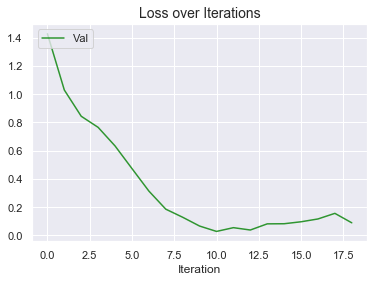

In [28]:
#Loss
plt.plot(clf.loss_curve_, color='green', alpha=0.8, label='Val')
plt.title("Loss over Iterations", fontsize=14)
plt.xlabel('Iteration')
plt.legend(loc='upper left')
plt.show()

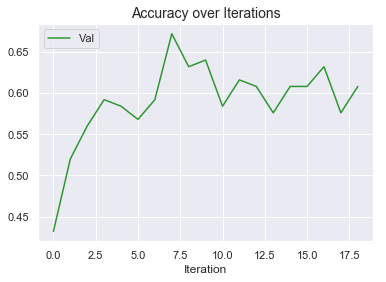

In [29]:
#Accuracy
plt.plot(clf.validation_scores_, color='green', alpha=0.8, label='Val')
plt.title("Accuracy over Iterations", fontsize=14)
plt.xlabel('Iteration')
plt.legend(loc='upper left')
plt.show()

In [30]:
#5 Fold Cross Validation
y_pred = cross_val_predict(clf, X_i, y, cv=5, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration 1, loss = 1.40094705
Validation score: 0.504000
Iteration 2, loss = 0.98621498
Validation score: 0.456000
Iteration 3, loss = 0.80158539
Validation score: 0.520000
Iteration 4, loss = 0.65912753
Validation score: 0.520000
Iteration 5, loss = 0.47848195
Validation score: 0.552000
Iteration 6, loss = 0.32837879
Validation score: 0.568000
Iteration 7, loss = 0.18516189
Validation score: 0.600000
Iteration 8, loss = 0.08391928
Validation score: 0.552000
Iteration 9, loss = 0.08370172
Validation score: 0.600000
Iteration 10, loss = 0.05567942
Validation score: 0.560000
Iteration 11, loss = 0.24885413
Validation score: 0.624000
Iteration 12, loss = 0.12735449
Validation score: 0.528000
Iteration 13, loss = 0.08400047
Validation score: 0.520000
Iteration 14, loss = 0.10574849
Validation score: 0.560000
Iteration 15, loss = 0.07279436
Validation score: 0.576000
Iteration 16, loss = 0.03431283
Validation score: 0.568000
Iteration 17, loss = 0.01647526
Validation score: 0.592000
Iterat

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


Iteration 2, loss = 0.86442838
Validation score: 0.480000
Iteration 3, loss = 0.69947314
Validation score: 0.464000
Iteration 4, loss = 0.52496045
Validation score: 0.528000
Iteration 5, loss = 0.37927585
Validation score: 0.592000
Iteration 6, loss = 0.22771495
Validation score: 0.584000
Iteration 7, loss = 0.11129280
Validation score: 0.608000
Iteration 8, loss = 0.06584128
Validation score: 0.544000
Iteration 9, loss = 0.03459681
Validation score: 0.592000
Iteration 10, loss = 0.03525594
Validation score: 0.616000
Iteration 11, loss = 0.02824749
Validation score: 0.568000
Iteration 12, loss = 0.02846617
Validation score: 0.560000
Iteration 13, loss = 0.01610920
Validation score: 0.584000
Iteration 14, loss = 0.02113370
Validation score: 0.536000
Iteration 15, loss = 0.02498081
Validation score: 0.544000
Iteration 16, loss = 0.07559427
Validation score: 0.544000
Iteration 17, loss = 0.10921874
Validation score: 0.552000
Iteration 18, loss = 0.09513927
Validation score: 0.536000
Itera

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


Iteration 1, loss = 1.37823811
Validation score: 0.464000
Iteration 2, loss = 0.96982189
Validation score: 0.472000
Iteration 3, loss = 0.82036325
Validation score: 0.536000
Iteration 4, loss = 0.64437901
Validation score: 0.536000
Iteration 5, loss = 0.51404487
Validation score: 0.560000
Iteration 6, loss = 0.36140473
Validation score: 0.568000
Iteration 7, loss = 0.22368813
Validation score: 0.568000
Iteration 8, loss = 0.11464925
Validation score: 0.576000
Iteration 9, loss = 0.08003871
Validation score: 0.576000
Iteration 10, loss = 0.06979516
Validation score: 0.616000
Iteration 11, loss = 0.03456179
Validation score: 0.640000
Iteration 12, loss = 0.03544883
Validation score: 0.624000
Iteration 13, loss = 0.03378257
Validation score: 0.584000
Iteration 14, loss = 0.03485053
Validation score: 0.592000
Iteration 15, loss = 0.08851661
Validation score: 0.600000
Iteration 16, loss = 0.07108150
Validation score: 0.544000
Iteration 17, loss = 0.08354872
Validation score: 0.576000
Iterat

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished


Results: 
              precision    recall  f1-score   support

          AD       0.92      0.99      0.95       260
      NOT_AD       1.00      0.97      0.98       780

    accuracy                           0.97      1040
   macro avg       0.96      0.98      0.97      1040
weighted avg       0.98      0.97      0.98      1040

Accuracy:  0.975


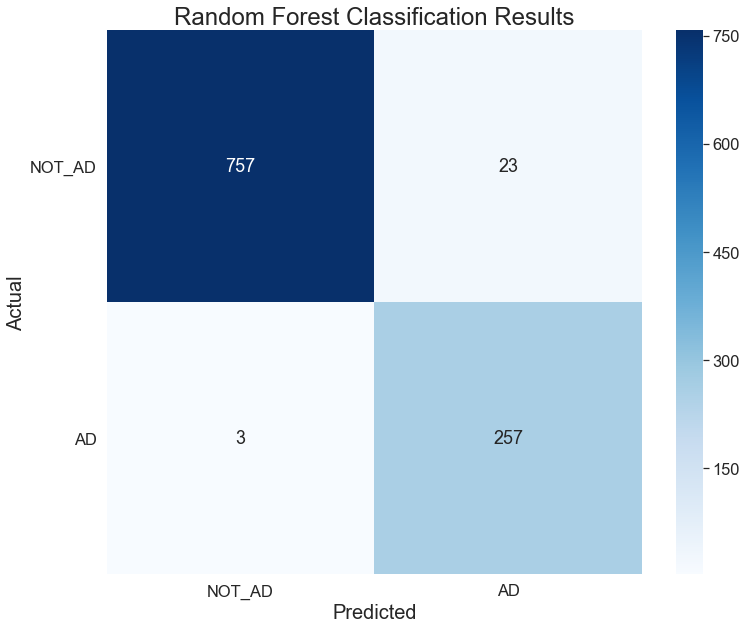

In [31]:
y_pred_Mut = y_pred
for label in labels:
    if label!='AD':
        y_pred_Mut = np.where(y_pred_Mut==label, 'NOT_AD', y_pred_Mut)

#Results
print("Results: ")
mat = confusion_matrix(y_Mut, y_pred_Mut, labels=['NOT_AD', 'AD'])
print(classification_report(y_Mut, y_pred_Mut))
print('Accuracy: ', accuracy_score(y_Mut, y_pred_Mut))
l = [mat[1][0], mat[0][0], mat[1][1], mat[0][1]]

#Heatmap
sns.set(font_scale=1.5)
plt.figure(figsize = (12,10))
sns.heatmap(mat, annot=True, cmap="Blues", fmt='g', xticklabels=['NOT_AD', 'AD'], yticklabels=['NOT_AD', 'AD'], annot_kws={"fontsize":18})
plt.yticks(rotation=0) 
plt.title('Random Forest Classification Results', fontsize=24)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
sns.set(font_scale=1)

Results: 
              precision    recall  f1-score   support

          AD       0.92      0.99      0.95       260
          CN       0.39      0.45      0.42       260
        EMCI       0.50      0.48      0.49       260
        LMCI       0.44      0.35      0.39       260

    accuracy                           0.57      1040
   macro avg       0.56      0.57      0.56      1040
weighted avg       0.56      0.57      0.56      1040

Accuracy:  0.5692307692307692


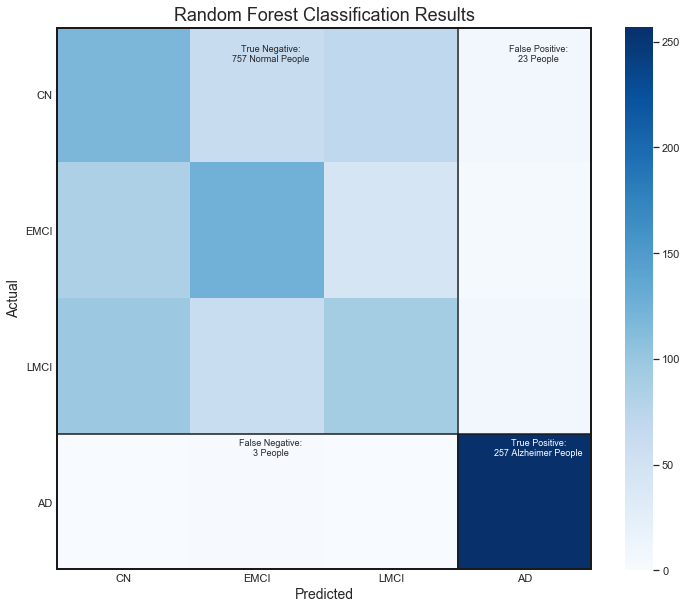

In [32]:
#Results
print("Results: ")
mat = confusion_matrix(y, y_pred, labels=labels)
print(classification_report(y, y_pred))
print('Accuracy: ', accuracy_score(y, y_pred))
#Heatmap
plot(mat, lbl=l)

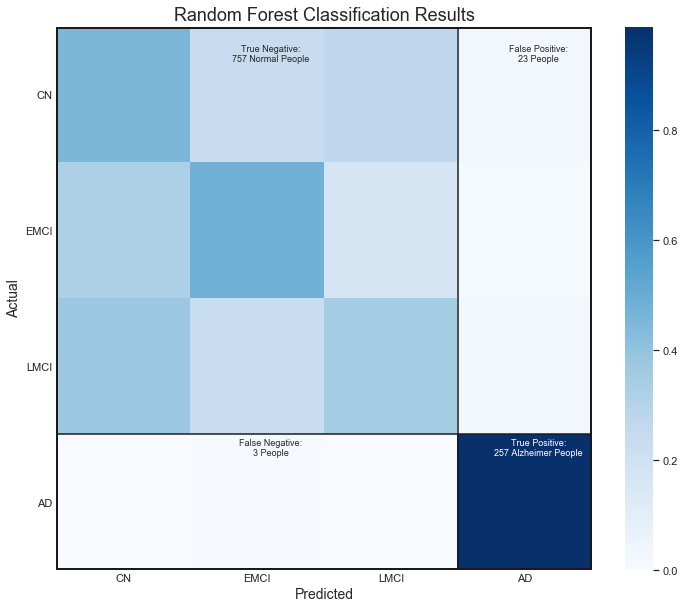

In [33]:
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

#Heatmap
plot(mat, lbl=l)